#**Wisconsin MCMC GerryChain Partition and Elections**

Most recent update: 11/25/2025

This file creates partitions and ensembles for Markov Chain, Partitions and Elections


---


Requirements:
- `wi_2024_gen_prec_graph.json` must already be downloaded and inputted in the default file folder. If not, see the instructions on `Wisconsin_SHP_File_Conversion.ipynb`





In [ ]:
# Install gerrychain packages
!pip install gerrychain[geo]
# Info used on dill here (https://dill.readthedocs.io/en/latest/index.html)
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
# Install additional dependencies
# Credit to the GerryChain documentation & tutorial for providing many of the
# examples done in this demo
from gerrychain import Graph, Partition, MarkovChain, Election, metrics
from gerrychain.proposals import propose_random_flip,recom
from gerrychain.updaters import Tally, cut_edges
from gerrychain.constraints import Validator, single_flip_contiguous, contiguous, within_percent_of_ideal_population # used for validators
from gerrychain.accept import always_accept
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
# Use pickle as an exporting tool if using python continuously
import dill as pickle

import random

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


#**Winconsin Election Addition**

In [ ]:
# Remove empty row warnings (to decide later)
import warnings
warnings.filterwarnings("ignore")

# Initialize the graph for chains
graph = Graph.from_json("./wi_2024_gen_prec_graph_non_nan.json")

# Find isolated precincts — islands
islands = [n for n, deg in graph.degree() if deg == 0]
print("Islands:", islands)

# Create the election first to validate data
election = Election(
    "PRES24",
    {"Dem":"PREDEM24", "Rep":"PREREP24"}
)

election_house = Election(
    "USHTOT24",
    {"Dem":"USHDEM24", "Rep":"USHREP24"}
)

election_sen = Election(
    "USSTOT24",
    {"Dem":"USSDEM24", "Rep":"USSREP24"}
)
# Create 3 plans: One for congressionalm one for state assembly, one for state district

cong_partition = Partition(
    graph,
    assignment="CONG_DIST",
    updaters={
        "population": Tally("PERSONS", alias="population"),
        "cut_edges": cut_edges,
        "PRES24": election
    }
)

updaters = {
        "population": Tally("PERSONS", alias="population"),
        "cut_edges": cut_edges,
        "PRES24": election,
        "SEN24": election_sen,
        "HOUSE24": election_house
    }

random_partition = Partition.from_random_assignment(graph, 9, epsilon=0.01, pop_col="PERSONS", updaters=updaters)

state_assem_partition = Partition(
    graph,
    assignment="SLDL_DIST",
    updaters=updaters
)

state_dist_partition = Partition(
    graph,
    assignment="SLDU_DIST",
    updaters={
        "population": Tally("PERSONS", alias="population"),
        "cut_edges": cut_edges,
        "PRES24": election
    }
)

# Prints output returns population info based on the plan chosen
def print_population(name, partition):
  print(f"\n{name} Plan Population:")
  for district, pop in partition["population"].items():
      print(f"  District {district}: {pop}")


# Sanity check
"""print_population("Congressional", cong_partition)
print_population("State Assembly", state_assem_partition)
print_population("State district", state_dist_partition)"""
print_population("Random Partition", random_partition)

Islands: []

Random Partition Plan Population:
  District 0: 658100.0
  District 1: 649859.0
  District 2: 650224.0
  District 3: 658404.0
  District 4: 652192.0
  District 5: 659318.0
  District 6: 650435.0
  District 7: 654990.0
  District 8: 660196.0


**Efficiency Gap measuring for democratic and republican party**

In [ ]:

# Function that calculate results based on the selected partition
# Returns: two outputs; the efficiency gap of the selected parition and the number of seats won by republicans
def summarize_election(partition):
  # Create the election based on the selected map "partition"
  election_map = partition["PRES24"]
  # Compute the efficiency gap using metrics.efficiency_gap
  efficiency_gap = metrics.efficiency_gap(election_map)

  # Compute the number of districts won by republicans
  rep_wins = election_map.seats("Rep")

  return efficiency_gap, rep_wins

# Function: Printing function for election results
# Returns: Print desired output based on the selected map, its efficiency gap and seats taken
def print_results(name, efficiency_gap, districts_won):
  print(f"{name} Voting Results")
  print(f"Efficiency gap: {efficiency_gap:0.4f}")
  print(f"Districts won: {districts_won}")
"""
eg_dem, rep_wins_dem = summarize_election(cong_partition)
print_results("Congressional Plan", eg_dem, rep_wins_dem)

eg_rep, rep_wins_rep = summarize_election(state_assem_partition)
print_results("State Assembly Plan", eg_rep, rep_wins_rep)

eg_comp, rep_wins_comp = summarize_election(state_dist_partition)
print_results("State District Plan", eg_rep, rep_wins_comp)
"""
eg_rand, rep_wins_rand = summarize_election(random_partition)
print_results("Random Partition Plan", eg_rand, rep_wins_rand)

Random Partition Plan Voting Results
Efficiency gap: -0.1612
Districts won: 6


#**Create Mini Ensembles for all 3 Partitions**

In [ ]:
# Parameters (Used for different versions)
total_plans = 1000
steps_between = 10
version_number = 1

In [ ]:
# Function to generate ensemble
# Returns a list of partitions of ensembles for the specified partition
def ensemble_generation(partition):
  tot_pop = sum(partition["population"].values())
  print(tot_pop)

  tot_districts = len(partition.parts)

  target_pop = tot_pop/tot_districts
  print(target_pop)

  # Add the ReCom proposal method
  proposal = partial(
      recom,
      pop_col="PERSONS",
      pop_target=target_pop,
      epsilon=0.01,
      node_repeats=2
  )

  # Create the Markov chain
  # Use propose random flip for now as computing power is too weak, seats for republican would stay the same
  chain = MarkovChain(
      proposal= proposal,
      constraints=[within_percent_of_ideal_population(partition, 0.01), contiguous],
      accept=always_accept,
      initial_state=partition,
      total_steps=total_plans*steps_between
  )
  ensemble =[]
  for step, partition in enumerate(chain):
      ensemble.append(partition)

  print(f"Generated {len(ensemble)} plans.")
  return ensemble

def print_steps(ensemble):
 # Sanity check
  for (i,part) in enumerate(ensemble):
    print(f"Step {i} Rep vote share for dist 1: "
      f"{part['PRES24'].percents('Rep')[1]:0.4f}")


"""cong_ensemble = ensemble_generation(cong_partition)
state_assem_ensemble = ensemble_generation(state_assem_partition)
state_dist_ensemble = ensemble_generation(state_dist_partition)"""

rand_ensemble = ensemble_generation(random_partition)
print_steps(rand_ensemble)
# Double check steps
#print_steps(cong_ensemble)


5893718.0
654857.5555555555
Generated 100 plans.
Step 0 Rep vote share for dist 1: 0.5950
Step 1 Rep vote share for dist 1: 0.5950
Step 2 Rep vote share for dist 1: 0.5950
Step 3 Rep vote share for dist 1: 0.5950
Step 4 Rep vote share for dist 1: 0.5950
Step 5 Rep vote share for dist 1: 0.5950
Step 6 Rep vote share for dist 1: 0.5950
Step 7 Rep vote share for dist 1: 0.5950
Step 8 Rep vote share for dist 1: 0.5950
Step 9 Rep vote share for dist 1: 0.5950
Step 10 Rep vote share for dist 1: 0.5950
Step 11 Rep vote share for dist 1: 0.5950
Step 12 Rep vote share for dist 1: 0.5950
Step 13 Rep vote share for dist 1: 0.5950
Step 14 Rep vote share for dist 1: 0.5950
Step 15 Rep vote share for dist 1: 0.5727
Step 16 Rep vote share for dist 1: 0.5727
Step 17 Rep vote share for dist 1: 0.5727
Step 18 Rep vote share for dist 1: 0.5671
Step 19 Rep vote share for dist 1: 0.5671
Step 20 Rep vote share for dist 1: 0.5671
Step 21 Rep vote share for dist 1: 0.5680
Step 22 Rep vote share for dist 1: 0.

In [ ]:
# Function to save ensembles in files
# Input: an ensemble filled with partitions
# Output: A pkl file decipherable by python libraries

def save_ensemble(ensemble, file):
  path = f"./{file}"
  with open(file, mode="wb") as i:
    pickle.dump(ensemble, i)
    print(f"file located at {path}")
    return ensemble

# Saved file names
cong_file = "cong_ensemble.pkl"
state_assem_file = "state_assem_ensemble.pkl"
state_dist_file = "state_dist_ensemble.pkl"
rand_file = "rand_ensemble-size-"+str(total_plans)+"-btwn-"+str(steps_between)+"v"+str(version_number)+".pkl"

# Save current ensembles into files
"""save_ensemble(cong_ensemble, cong_file)
save_ensemble(state_assem_ensemble, state_assem_file)
save_ensemble(state_dist_ensemble, state_dist_file)
"""
save_ensemble(rand_ensemble, rand_file)


file located at ./rand_ensemble-size-10-btwn-10v1.pkl


[<Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 parts]>,
 <Partition [9 p

In [ ]:
def compute_total_rep_wins(ensemble):
  """Computes total republican wins for a specified ensemble
  Inputs: a designated ensemble as a partition in lists
  Output: two lists given; an efficiency gap list and the total republican wins for that ensemble
  """
  # Output results

  # Store efficiency gap and total republican wins
  # Using the tip create a list that already has the same amount as the chain instead of gradually increasing it
  n = len(ensemble)
  rep_wins_list = [None]*n
  efficiency_gap_list =[None]*n

  # Iterate through all values on the markov chain

  for (i,part) in enumerate(ensemble):
    if i%steps_between == 0:
      # Sum all wins for republicans
      rep_wins_list[i//steps_between]=part["PRES24"].seats("Rep")

      # Sum all efficiency gaps for republicans
      efficiency_gap_list[i//steps_between] = metrics.efficiency_gap(part["PRES24"])


  # Remove all empty spaces in the list
  samples = (n+steps_between-1)//steps_between

  # Slice the array (https://www.geeksforgeeks.org/python/python-arrays/)
  rep_wins_list = rep_wins_list[:samples]
  efficiency_gap_list = efficiency_gap_list[:samples]

  return rep_wins_list, efficiency_gap_list

# Set the correct outputs and lists for the specified functions for sanity check on next cell
""" cong_rep_wins, cong_eff_gap = compute_total_rep_wins(cong_ensemble)
state_assem_rep_wins, state_assem_eff_gap = compute_total_rep_wins(state_assem_ensemble)
state_dist_rep_wins, state_dist_eff_gap = compute_total_rep_wins(state_dist_ensemble) """
rand_rep_wins, rand_eff_gap = compute_total_rep_wins(rand_ensemble)

In [ ]:
# Sanity check for list of republican wins
print("Republican Wins Ensemble Lists")
"""
print(f"  Congressional Republican Wins:{cong_rep_wins}")
print(f"  State Assembly Republican Wins:{state_assem_rep_wins}")
print(f"  State Districting Republican Wins:{state_dist_rep_wins}\n")
"""
print(f"  Random Districting Republican Wins:{rand_rep_wins}\n")

# Sanity check for list of efficency gap for republicans
print("Efficiency Gap Lists for Ensembles")
"""print(f"  Congressional Efficiency Gap:{cong_eff_gap}")
print(f"  State Assembly Efficiency Gap:{state_assem_eff_gap}")
print(f"  State Districting Efficiency Gap:{state_dist_eff_gap}")"""
print(f"  State Districting Efficiency Gap:{rand_eff_gap}")


Republican Wins Ensemble Lists
  Random Districting Republican Wins:[6, 7, 7, 7, 6, 6, 6, 6, 6, 7]

Efficiency Gap Lists for Ensembles
  State Districting Efficiency Gap:[-0.16120554807025259, -0.27660832091697357, -0.27600134289801553, -0.27971689214181833, -0.16594639400687194, -0.16594639400687194, -0.1637332861932555, -0.16245159105190213, -0.16232651139160778, -0.2747024158794719]


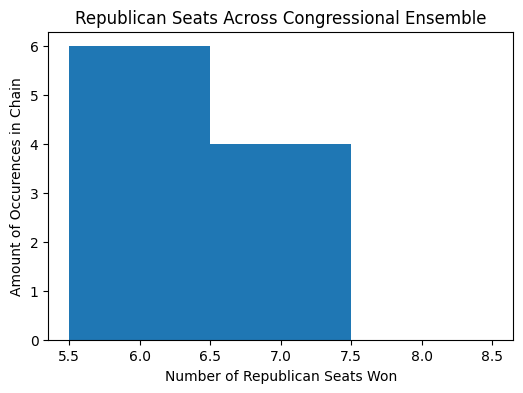

<Figure size 640x480 with 0 Axes>

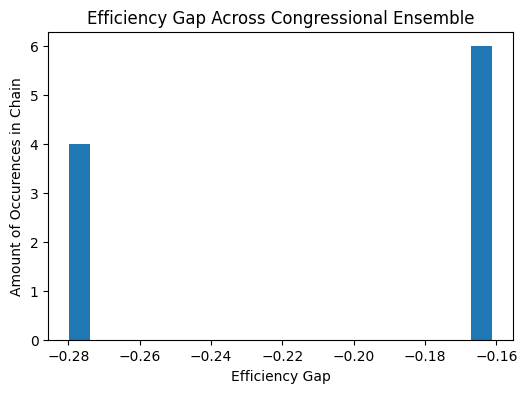

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create the list for the figures to display
# Figure for republican seats won
# Set the range of bins to be dynamic since number of seats is small in this case
plt.figure(figsize=(6,4))
plt.hist(rand_rep_wins,
         bins=range(min(rand_rep_wins), max(rand_rep_wins)+3),
         align="left")
plt.title("Republican Seats Across Congressional Ensemble")
plt.xlabel("Number of Republican Seats Won")
plt.ylabel("Amount of Occurences in Chain")

plt.show()

plt.savefig("RepSeats2024-size-"+str(total_plans)+"-btwn-"+str(steps_between)+"v"+str(version_number)+".png")

# Figure for efficiency gap
# Use a fixed amount of bins in this case since efficiency gap varies alot
plt.figure(figsize=(6,4))
plt.hist(rand_eff_gap, bins=20)
plt.title("Efficiency Gap Across Congressional Ensemble")
plt.xlabel("Efficiency Gap")
plt.ylabel("Amount of Occurences in Chain")

plt.show()

plt.savefig("EffGap2024-size-"+str(total_plans)+"-btwn-"+str(steps_between)+"v"+str(version_number)+".png")

